In [1]:
import pandas as pd

%matplotlib inline

## NFL PXP Data

NFL play-by-play data is loaded from csv format.  A few convenient data fields are added to easy computation of possession value.

In [2]:
def load_year(year):
    cols = [
        'GameID', 'Drive', 'qtr', 'down', 'time', 'SideofField', 'yrdln', 'yrdline100', 
        'posteam', 'DefensiveTeam', 'desc', 'Touchdown', 'ExPointResult', 'TwoPointConv', 
        'DefTwoPoint', 'Safety','Onsidekick', 'PuntResult', 'PlayType', 'FieldGoalResult', 
        'FieldGoalDistance', 'PosTeamScore', 'DefTeamScore', 'ScoreDiff', 'AbsScoreDiff', 
        'HomeTeam', 'AwayTeam'
    ]
    pxp = pd.read_csv('../data/nfl_pxp/pxp_{}.csv.gz'.format(year), usecols=cols)

    # Compute half.  For OT, use half = 3.
    pxp['half'] = 1 * ((pxp['qtr'] == 1) | (pxp['qtr'] == 2)) + \
        2 * ((pxp['qtr'] == 3) | (pxp['qtr'] == 4)) + \
        3 * ((pxp['qtr'] > 4))
    
    # Convert PosTeamScore/DefTeamScore to HomeScore/AwayScore
    pxp['HomeScore'] = (pxp['HomeTeam'] == pxp['posteam']) * pxp['PosTeamScore'] + \
        (pxp['HomeTeam'] == pxp['DefensiveTeam']) * pxp['DefTeamScore']
    pxp['AwayScore'] = (pxp['AwayTeam'] == pxp['posteam']) * pxp['PosTeamScore'] + \
        (pxp['AwayTeam'] == pxp['DefensiveTeam']) * pxp['DefTeamScore']
    # Fill in missing values due to timeouts leaving NAs in the dataset
    pxp.loc[:, ['HomeScore', 'AwayScore']] = pxp[['HomeScore', 'AwayScore']].fillna(method='ffill')
    return pxp

## Extract Kickoffs and Possession Starts

We need to extract kickoffs and possession starts in order to build a possession value calculator.  To do that, we first isolate kickoffs by using PlayType.  Then we drill down by GameID and Drive # (ignoring kickoffs) and take the first play of the drive.  Then we have to find the next score in the game for each possession.  We compute differences in the Home and Away scores and then fill those backward.  We treat Home scores as positive and Away scores as negative.  We only consider possession value within a half.  So if there is no score before halftime or the end of the game, the value is 0.

In [3]:
def extract_kickoffs_and_possessions(pxp):
    # extract kickoffs
    kickoffs = pxp.loc[pxp['PlayType'] == 'Kickoff']
    # Exclude kickoffs and groupby GameID and Drive
    game_drives = pxp.loc[pxp['PlayType'] != 'Kickoff'].groupby(['GameID', 'Drive'])
    # Take first play
    poss_starts = game_drives.head(1)

    # Concatenate kickoffs and first plays, sort, and reindex
    ko_and_poss = pd.concat([kickoffs, poss_starts])\
        .sort_values(['GameID', 'Drive', 'down'], na_position='first')
    ko_and_poss.reset_index(drop=True, inplace=True)
    
    # Group by game halves
    game_halves = ko_and_poss.groupby(['GameID', 'half'])
    # Compute changes in the scores.  + for Home and - for Away.
    tmp = -game_halves['HomeScore'].diff(-1) + game_halves['AwayScore'].diff(-1)
    # Backfill the score change so that each possession now has a value for next score in the game
    ko_and_poss['NextScore'] = tmp.replace(to_replace=0., method='bfill').fillna(0)
    
    # Determine if the possessing team is home or away
    posteam = ko_and_poss['posteam']
    hometeam = ko_and_poss['HomeTeam']
    awayteam = ko_and_poss['AwayTeam']
    posteam_is_home = (posteam == hometeam).astype(int)
    posteam_is_away = (posteam == awayteam).astype(int)
    # NextScore is unchanged if posteam == hometeam and negated if posteam == awayteam
    ko_and_poss['PossessionValue'] = ko_and_poss['NextScore'] * \
        (posteam_is_home - posteam_is_away)

    # Retrict to first and third quarters
    first_and_third_qtr = (ko_and_poss['qtr'] == 1) | (ko_and_poss['qtr'] == 3)
    ko_and_poss_first_and_third = ko_and_poss.loc[first_and_third_qtr]
    return ko_and_poss_first_and_third

## Load Available Data

In [4]:
years = [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]

ko_and_poss = []
for year in years:
    pxp = load_year(year)
    ko_and_poss.append(extract_kickoffs_and_possessions(pxp))
    
ko_and_poss = pd.concat(ko_and_poss)

/usr/local/var/pyenv/versions/3.6.1/envs/data8/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2850: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [5]:
print(ko_and_poss.info())
ko_and_poss.head(20)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33758 entries, 0 to 8505
Data columns (total 32 columns):
GameID               33758 non-null int64
Drive                33758 non-null int64
qtr                  33758 non-null int64
down                 22698 non-null float64
time                 33757 non-null object
SideofField          33758 non-null object
yrdln                33758 non-null float64
yrdline100           33758 non-null float64
posteam              33591 non-null object
DefensiveTeam        33591 non-null object
desc                 33758 non-null object
Touchdown            33758 non-null int64
ExPointResult        55 non-null object
TwoPointConv         1 non-null object
DefTwoPoint          0 non-null object
Safety               33758 non-null int64
Onsidekick           33758 non-null int64
PuntResult           0 non-null object
PlayType             33758 non-null object
FieldGoalResult      0 non-null object
FieldGoalDistance    0 non-null float64
PosTeamScore  

,GameID,Drive,qtr,down,time,SideofField,yrdln,yrdline100,posteam,DefensiveTeam,...,DefTeamScore,ScoreDiff,AbsScoreDiff,HomeTeam,AwayTeam,half,HomeScore,AwayScore,NextScore,PossessionValue
0,2009091000,1,1,NaN,15:00,TEN,30.0,30.0,PIT,TEN,...,0.0,0.0,0.0,PIT,TEN,1,0.0,0.0,7.0,7.0
1,2009091000,1,1,1.0,14:53,PIT,42.0,58.0,PIT,TEN,...,0.0,0.0,0.0,PIT,TEN,1,0.0,0.0,7.0,7.0
2,2009091000,2,1,1.0,13:16,TEN,2.0,98.0,TEN,PIT,...,0.0,0.0,0.0,PIT,TEN,1,0.0,0.0,7.0,-7.0
3,2009091000,3,1,1.0,11:24,TEN,43.0,43.0,PIT,TEN,...,0.0,0.0,0.0,PIT,TEN,1,0.0,0.0,7.0,7.0
4,2009091000,4,1,1.0,08:20,TEN,11.0,89.0,TEN,PIT,...,0.0,0.0,0.0,PIT,TEN,1,0.0,0.0,7.0,-7.0
5,2009091000,5,1,1.0,06:44,PIT,27.0,73.0,PIT,TEN,...,0.0,0.0,0.0,PIT,TEN,1,0.0,0.0,7.0,7.0
6,2009091000,6,1,1.0,04:49,TEN,26.0,74.0,TEN,PIT,...,0.0,0.0,0.0,PIT,TEN,1,0.0,0.0,7.0,-7.0
7,2009091000,7,1,1.0,01:38,PIT,21.0,79.0,PIT,TEN,...,0.0,0.0,0.0,PIT,TEN,1,0.0,0.0,7.0,7.0
8,2009091000,8,1,1.0,00:06,PIT,44.0,44.0,TEN,PIT,...,0.0,0.0,0.0,PIT,TEN,1,0.0,0.0,7.0,-7.0
16,2009091000,14,3,NaN,15:00,PIT,30.0,30.0,TEN,PIT,...,7.0,0.0,0.0,PIT,TEN,2,7.0,7.0,-3.0,3.0


## Kickoff Value to the Return Team

In the dataset, the return team is considered the possessing team.  So computing the average value represents the value to the return team.

In [6]:
# Restrict to kickoff events
ko = ko_and_poss['PlayType'] == 'Kickoff'
# Compute the average kickoff value
ko_and_poss.loc[ko]['PossessionValue'].mean()

0.59385382059800662

## Possession Value 

Now we group by each yard line, excluding kickoffs, and compute the average possession value.

In [7]:
possession_values = ko_and_poss.loc[~ko].groupby('yrdline100')['PossessionValue'].mean()
possession_values

yrdline100
1.0     6.636364
2.0     2.287879
3.0     6.777778
4.0     5.800000
5.0     5.866667
6.0     6.071429
7.0     4.583333
8.0     4.904762
9.0     4.380952
10.0    5.684211
11.0    5.260870
12.0    4.400000
13.0    4.815789
14.0    4.406250
15.0    3.451613
16.0    4.000000
17.0    4.750000
18.0    4.571429
19.0    4.575000
20.0    4.363636
21.0    3.829268
22.0    5.594595
23.0    5.270270
24.0    4.659091
25.0    3.347826
26.0    3.900000
27.0    3.666667
28.0    4.421053
29.0    3.911111
30.0    1.868132
          ...   
70.0    0.781690
71.0    0.684211
72.0    0.985714
73.0    1.047059
74.0    1.206612
75.0    0.890068
76.0   -0.004175
77.0    0.821569
78.0    0.881323
79.0    0.189189
80.0    0.431260
81.0    0.794055
82.0    0.403846
83.0    1.038560
84.0    0.403382
85.0    0.051345
86.0    0.386768
87.0   -0.049080
88.0    0.400621
89.0   -0.219880
90.0   -0.524631
91.0    0.376582
92.0   -0.081181
93.0   -0.545918
94.0   -0.607362
95.0   -0.331081
96.0   -0.588710
97.

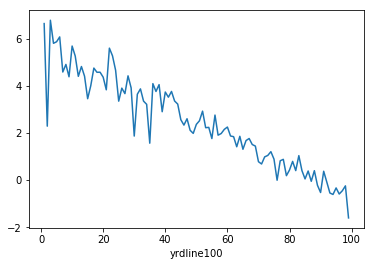

In [8]:
possession_values.plot()